In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

ROW_LIMIT = 10000
COLUMNS = ["starttime", "stoptime", "start station id", "end station id"]
TARGET_STATION_ID = "529"


def analyze(row_limit, threshold_out=1, tree_count=10, period_minutes=5, k_folds=5):
    """
    We can tune the following parameters:
    - number of rows we analyze
    - number of folds in our standard k-fold cross-validation
    - number of bicycles taken out in the period to be considered in the positive class
    - number of trees in our random forest
    - number of minutes in our period
    """
    start = time.time()
    df = pd.read_csv("data/july_thru_sept.csv", usecols=COLUMNS)
    # Convert to timestamps 
    df["starttime"] = pd.to_datetime(df["starttime"])
    df["stoptime"] = pd.to_datetime(df["stoptime"])

    # Convert int64index to datetime index
    # Group using timegrouper and create new column for start period and stop period
    df = df.set_index(pd.DatetimeIndex(df['starttime']))
    start_time_group_by = df.groupby(pd.TimeGrouper('5Min'),as_index=False).apply(lambda x: x['starttime'])
    df['start_period'] = start_time_group_by.index.get_level_values(0)

    df = df.set_index(pd.DatetimeIndex(df['stoptime']))
    stop_time_group_by = df.groupby(pd.TimeGrouper('{}Min'.format(period_minutes)),as_index=False).apply(lambda x: x['stoptime'])
    df['stop_period'] = stop_time_group_by.index.get_level_values(0)

    # Create two sub dataframes, grouping on and aggregating start data and then stop data
    grouped_by = df.groupby(['start_period', 'start station id'])
    df_start = pd.DataFrame({'started_count' : grouped_by.size()}).reset_index()
    df_start.columns = ["period", "station_id", "start_count"]

    grouped_by = df.groupby(['stop_period', 'end station id'])
    df_stop = pd.DataFrame({'stopped_count' : grouped_by.size()}).reset_index()
    df_stop.columns = ["period", "station_id", "stop_count"]

    # Combine these two dataframes and fill N/A values to 0
    df_combined = pd.concat([df_start, df_stop])
    df_combined = df_combined.fillna(0)

    # Let's group on period and station_id and then sum up along start_count and stop_count
    # And reset the multi-level index so we have a normal DataFrame
    aggregate_data = df_combined.groupby(['period', 'station_id']).sum().reset_index()

    # Let's construct a pivot table
    pivoted = pd.pivot_table(
        aggregate_data,
        index=["period"],
        columns=["station_id"],
        aggfunc=np.sum,
        fill_value=0)

    # Go from multilevel index of start > station_id and stop > station_id to {station_id}_start and {station_id}_stop
    deeper_cols = pivoted.columns.get_level_values(1)
    top_level_cols = pivoted.columns.get_level_values(0)

    # Flattening the columns
    resultant_cols = []    
    for i, station_id in enumerate(deeper_cols):
        if top_level_cols[i] == "start_count":
            resultant_cols.append("{}_{}".format(station_id, "out"))
        else:
            resultant_cols.append("{}_{}".format(station_id, "in"))
    pivoted.columns = resultant_cols
    pivoted = pivoted.reset_index()
    print "{} rows in the pivoted table".format(len(pivoted))
    X = pivoted.copy()
    # Turn number of out in station TARGET_STATION_ID into 1s and 0s
    answer_series = (
        pivoted["{}_out".format(TARGET_STATION_ID) ] > threshold_out).apply(int)
    X = X[:-1]
    y = answer_series[1:]

    classifier = RandomForestClassifier(n_estimators=tree_count)
    scores = cross_validation.cross_val_score(
        classifier,
        X,
        y,
        cv=k_folds
    )

    end = time.time()
    mean_accuracy = np.mean(scores)
    print "Rows: {}, k={}".format(row_limit, k_folds)
    print "Mean accuracy: {}".format(mean_accuracy)
    print "Standard deviation: {}".format(np.std(scores))
    print "Took {}s".format(end - start)
    return mean_accuracy


In [7]:
analyze(1000000)

6920 rows in the pivoted table
Rows: 1000000, k=5
Mean accuracy: 0.846800433839
Standard deviation: 0.0135608201403
Took 314.366345167s


In [13]:
counts = [10, 20, 40]
accs = []
for tc in counts:
    print "{} trees".format(tc)
    accs.append(analyze(10000, tree_count=tc))


10 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.834920634921
Standard deviation: 0.104557279717
Took 18.0323660374s
20 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.863756613757
Standard deviation: 0.115769081942
Took 21.5619990826s
40 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.849470899471
Standard deviation: 0.117887943647
Took 25.3746700287s


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
from matplotlib import pyplot as plt

10 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.863492063492
Standard deviation: 0.10181027118
Took 59.6095778942s


20 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.834656084656
Standard deviation: 0.0997954291739
Took 62.9534199238s


40 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.871428571429
Standard deviation: 0.132864823127
Took 66.8124659061s


100 trees
140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.856878306878
Standard deviation: 0.137190165921
Took 71.0440227985s




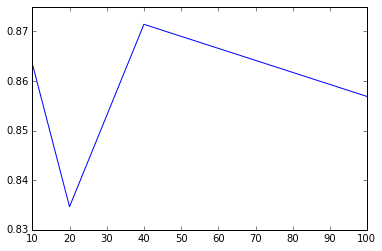

In [19]:
counts = [10, 20, 40, 100]
accs = []
for tc in counts:
    print "{} trees".format(tc)
    accs.append(analyze(10000, tree_count=tc))
    print "\n"
plt.plot(counts, accs)

140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.842328042328
Standard deviation: 0.1161113492
Took 186.666893005s


140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.819923371648
Standard deviation: 0.152777027106
Took 190.342999935s


140 rows in the pivoted table
Rows: 10000, k=5
Mean accuracy: 0.738779419814
Standard deviation: 0.166961479106
Took 194.119710922s




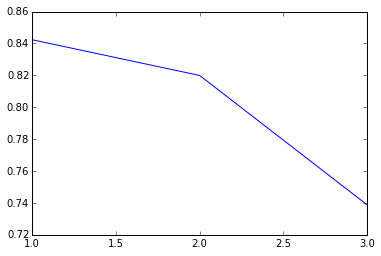

In [21]:
thresholds = [1, 2, 3, 5]
accs = []
for to in thresholds:
    accs.append(analyze(10000, tree_count=40, threshold_out=to))
    print "\n"
plt.plot(thresholds, accs)

994 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.84252063347
Standard deviation: 0.174280565393
Took 313.363794804s


415 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.876655052265
Standard deviation: 0.0367909897328
Took 328.793627977s


394 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.811608244077
Standard deviation: 0.042031678653
Took 344.247775793s


391 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.820654872554
Standard deviation: 0.0339002512563
Took 359.149614811s




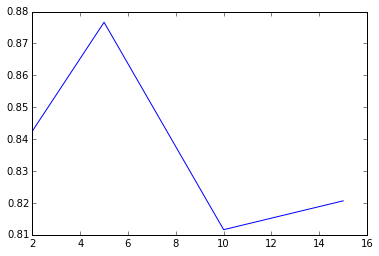

In [22]:
lengths = [2, 5, 10, 15]
accs = []
for length in lengths:
    accs.append(analyze(50000, tree_count=40, threshold_out=1, period_minutes=length))
    print "\n"
plt.plot(lengths, accs)

415 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.864401858304
Standard deviation: 0.0951605162627
Took 438.220816851s


415 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.869396051103
Standard deviation: 0.0486123422472
Took 456.012518883s


415 rows in the pivoted table
Rows: 50000, k=5
Mean accuracy: 0.874274099884
Standard deviation: 0.0596159452359
Took 474.407039881s




ValueError: x and y must have same first dimension

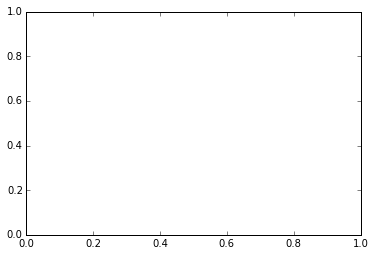

In [23]:
tree_counts = [40, 100, 200]
accs = []
for tc in tree_counts:
    accs.append(analyze(50000, tree_count=tc, threshold_out=1, period_minutes=5))
    print "\n"

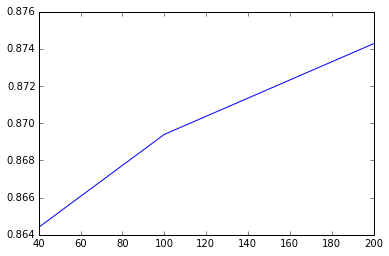

In [24]:
plt.plot(tree_counts, accs)

In [25]:
analyze(1000000, tree_count=200, threshold_out=1, period_minutes=5)

6920 rows in the pivoted table
Rows: 1000000, k=5
Mean accuracy: 0.873250953987
Standard deviation: 0.0224396149915
Took 898.113418818s


0.87325095398710173

In [26]:
analyze(1200000, tree_count=500, threshold_out=1, period_minutes=5)

8142 rows in the pivoted table
Rows: 1200000, k=5
Mean accuracy: 0.87753175687
Standard deviation: 0.0101650338518
Took 1438.6476028s


0.87753175687006379

In [31]:
analyze(500000000, tree_count=500, threshold_out=1, period_minutes=5)

/Users/suneel0101/anaconda/envs/citi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


ValueError: Unknown string format

In [34]:
df = pd.read_csv("data/july_thru_sept.csv", usecols=COLUMNS)

/Users/suneel0101/anaconda/envs/citi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
df.size

14217684

In [43]:
df[df["stoptime"].isnull() == True]

,starttime,stoptime,start station id,end station id


In [ ]:
df = pd.read_csv("data/july_thru_sept.csv", usecols=COLUMNS)
# Convert to timestamps 
try:
    df["starttime"] = pd.to_datetime(df["starttime"])
except Exception as e:
    import pdb; pdb.set_trace()

--Return--
> <ipython-input-45-c1cff856fa26>(6)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) e
ValueError(u'Unknown string format',)
(Pdb) values
*** NameError: name 'values' is not defined
(Pdb) locals()
{'disp': <function disp at 0x104e00848>, 'lstsq': <function lstsq at 0x104e15b90>, 'all': <function all at 0x104d5acf8>, 'dist': <function dist at 0x1081d07d0>, 'issubsctype': <function issubsctype at 0x104a90b18>, 'sca': <function sca at 0x109d199b0>, 'savez': <function savez at 0x104e751b8>, 'entropy': <function entropy at 0x10a9b9f50>, 'restoredot': <function restoredot at 0x104d40500>, 'ptp': <function ptp at 0x104d5ae60>, 'Subplot': <class 'matplotlib.axes._subplots.AxesSubplot'>, 'frange': <function frange at 0x10a99c0c8>, 'PackageLoader': <class 'numpy._import_tools.PackageLoader'>, 'to': 3, 'rec2csv': <function rec2csv at 0x10a99f668>, 'ylabel': <function ylabel at 0x109d200c8>, 'tc': 200, 'norm': <function norm at 0x104e2c320>, 'MultipleLocator': <class 'matplotlib.ti

In [ ]:
for i, y in enumerate(df["starttime"]):
    print i
    try:
        pd.to_datetime(y)
    except Exception as e:
        import pdb; pdb.set_trace()